In [88]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from dataset import Burgers_Dataset, NaiverStokes_Dataset
from unet2d import Unet2D
from unet3d import Unet3D
from diffuser import GaussianDiffusion

In [2]:
ds = Burgers_Dataset("../data/burgers_data_Nt100_v1e-02_N200.mat")
initial_cond = ds[0:1]['y']
ground_truth = ds[0:1]['x']
del ds

Loaded 200 samples from ../data/burgers_data_Nt100_v1e-02_N200.mat
Shape of x: torch.Size([200, 1, 100, 128])


In [3]:
device = torch.device("cuda:0")

In [4]:
model = Unet2D(
    channels=1,
    cond_channels=1,
    channel_mults=(1, 2, 4, 8),
    init_conv_channels=32,
    init_conv_kernel_size=5
)
diffusion_model = GaussianDiffusion(
    model=model,
    sample_size=(1, 100, 128),
    timesteps=800,
    objective='pred_x0',
).to(device)

In [5]:
weigths = torch.load("../ckpts/ddpm/burgers_0.2phyloss(ec)/ckpt.pt", map_location={'cuda:1':'cuda:0'})
diffusion_model.model.load_state_dict(weigths)

<All keys matched successfully>

In [6]:
initial_cond_tile = initial_cond.repeat(32, 1, 1)
initial_cond_tile.shape

torch.Size([32, 1, 128])

In [7]:
with torch.no_grad():
    prediction_tile = diffusion_model.sample(cond=initial_cond_tile)
    prediction_tile = prediction_tile.cpu().detach().numpy()

DDPM sampling: 100%|██████████| 800/800 [04:21<00:00,  3.06it/s]


In [8]:
torch.cuda.empty_cache()

In [12]:
prediction_tile = prediction_tile.squeeze()
ground_truth = ground_truth.squeeze()
initial_cond = initial_cond.squeeze()

In [14]:
initial_cond.max(), initial_cond.min()

(tensor(0.3142), tensor(-0.5368))

In [64]:
hists = []
for i in range(32):
    hist, bin_edges = np.histogram(prediction_tile[i].flatten(), bins=50)
    hists.append(hist)
hists = np.array(hists)
hists_mean = hists.mean(axis=0)
hists_std = hists.std(axis=0)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
hist_ground_truth, _ = np.histogram(ground_truth.flatten(), bins=50)

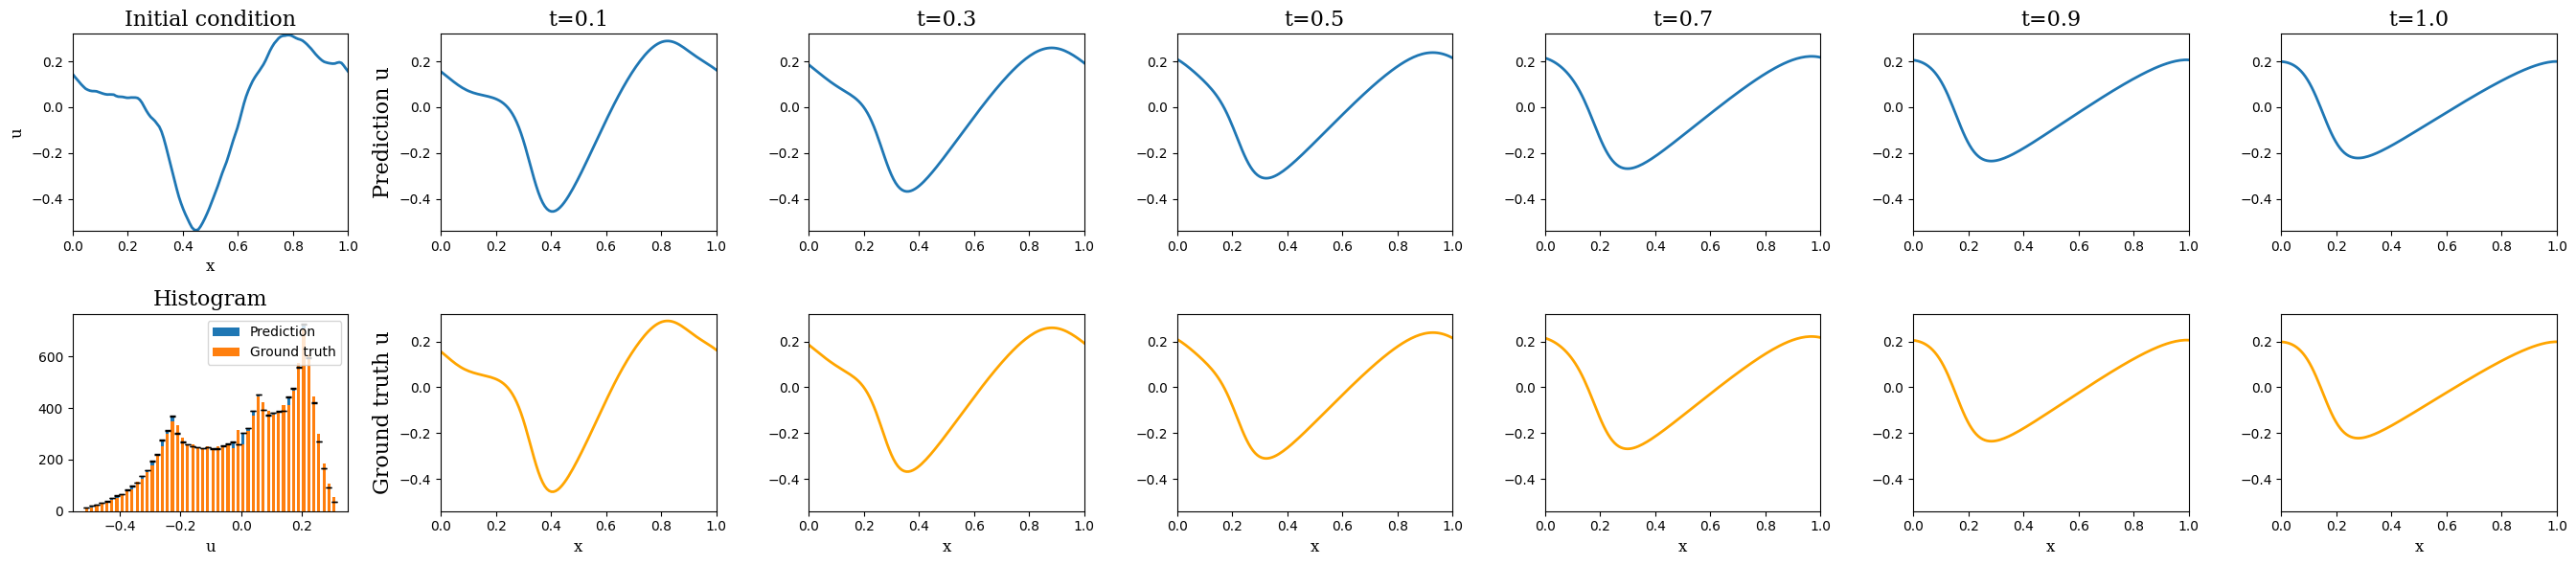

In [74]:
x_range = np.linspace(0, 1, 128)
fig, ax = plt.subplots(2, 7, figsize=(27, 6))
ax[0, 0].plot(x_range, initial_cond, linewidth=2)
ax[0, 0].set_title('Initial condition', fontfamily='serif', fontsize=16)
ax[0, 0].set_xlabel('x', fontfamily='serif', fontsize=12)
ax[0, 0].set_ylabel('u', fontfamily='serif', fontsize=12)
ax[0, 0].set_xlim(0, 1.0)
ax[0, 0].set_ylim(-0.54, 0.32)

ax[1, 0].bar(bin_centers, hists_mean, width=0.01, label='Prediction')
ax[1, 0].bar(bin_centers, hist_ground_truth, width=0.01, label='Ground truth')
ax[1, 0].errorbar(bin_centers, hists_mean, yerr=hists_std, fmt='none', ecolor='black', capsize=2)
# add legend for this subplot only
handles, labels = ax[1, 0].get_legend_handles_labels()
ax[1, 0].legend(handles, labels, loc='upper right')
ax[1, 0].set_title('Histogram', fontfamily='serif', fontsize=16)
ax[1, 0].set_xlabel('u', fontfamily='serif', fontsize=12)

for i in range(5):
    ax[0, i+1].plot(x_range, prediction_tile[0, (2*i+1)*10], linewidth=2)
    ax[0, i+1].set_title(f't={0.1*(2*i+1):.1f}', fontfamily='serif', fontsize=16)
    ax[0, i+1].set_xlim(0, 1.0)
    ax[0, i+1].set_ylim(-0.54, 0.32)


    ax[1, i+1].plot(x_range, ground_truth[(2*i+1)*10], linewidth=2, color='orange')
    ax[1, i+1].set_xlim(0, 1.0)
    ax[1, i+1].set_ylim(-0.54, 0.32)
    ax[1, i+1].set_xlabel('x', fontfamily='serif', fontsize=12)


    if i == 0:
        ax[0, i+1].set_ylabel('Prediction u', fontfamily='serif', fontsize=16)
        ax[1, i+1].set_ylabel('Ground truth u', fontfamily='serif', fontsize=16)

ax[0, 6].plot(x_range, prediction_tile[0, -1], linewidth=2)
ax[0, 6].set_title(f't=1.0', fontfamily='serif', fontsize=16)
ax[0, 6].set_xlim(0, 1.0)
ax[0, 6].set_ylim(-0.54, 0.32)


ax[1, 6].plot(x_range, ground_truth[-1], linewidth=2, color='orange')
ax[1, 6].set_xlabel('x', fontfamily='serif', fontsize=12)
ax[1, 6].set_xlim(0, 1.0)
ax[1, 6].set_ylim(-0.54, 0.32)
plt.tight_layout()
# plt.subplots_adjust(wspace=0.15, hspace=0.2)
plt.savefig("../burgers_pred.png", dpi=300)

In [76]:
ds = NaiverStokes_Dataset('../data/ns_data_T20_v1e-03_N200.mat')
initial_cond = ds[0:1]['y']
ground_truth = ds[0:1]['x']
del ds

Loaded 200 samples from ../data/ns_data_T20_v1e-03_N200.mat
Shape of x: torch.Size([200, 1, 20, 64, 64])


In [94]:
x_range = torch.linspace(0, 1, 64+1)[:-1]
y_range = torch.linspace(0, 1, 64+1)[:-1]
X, Y = torch.meshgrid(x_range, y_range, indexing='ij')

In [82]:
model = Unet3D(
            channels=1,
            cond_channels=1,
            channel_mults=(1, 2, 4, 8, 16),
            init_conv_channels=32,
            init_conv_kernel_size=5
)

diffuser = GaussianDiffusion(
    model=model,
    sample_size=(1, 20, 64, 64),
    timesteps=1000,
    objective='pred_x0',
    output_mask=None,
)
diffuser = diffuser.to('cuda:0')

In [83]:
weigths = torch.load(f"../ckpts/ddpm/ns_0.10phyloss(ec)/ckpt_clean.pt", map_location={'cuda:1':'cuda:0'})
diffuser.model.load_state_dict(weigths)

<All keys matched successfully>

In [84]:
initial_cond_tile = initial_cond.repeat(8, 1, 1, 1)
initial_cond_tile.shape

torch.Size([8, 1, 64, 64])

In [85]:
with torch.no_grad():
    prediction_tile = diffuser.sample(cond=initial_cond_tile)
    prediction_tile = prediction_tile.cpu().detach()

DDPM sampling: 100%|██████████| 1000/1000 [05:39<00:00,  2.95it/s]


In [86]:
torch.cuda.empty_cache()

In [89]:
initial_cond = initial_cond.squeeze()
ground_truth = ground_truth.squeeze()
prediction_tile = prediction_tile.squeeze()

In [90]:
hists = []
for i in range(8):
    hist, bin_edges = np.histogram(prediction_tile[i].flatten(), bins=50)
    hists.append(hist)
hists = np.array(hists)
hists_mean = hists.mean(axis=0)
hists_std = hists.std(axis=0)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
hist_ground_truth, _ = np.histogram(ground_truth.flatten(), bins=50)

In [98]:
X = X.numpy()
Y = Y.numpy()
prediction_tile = prediction_tile.numpy()
ground_truth = ground_truth.numpy()
initial_cond = initial_cond.numpy()

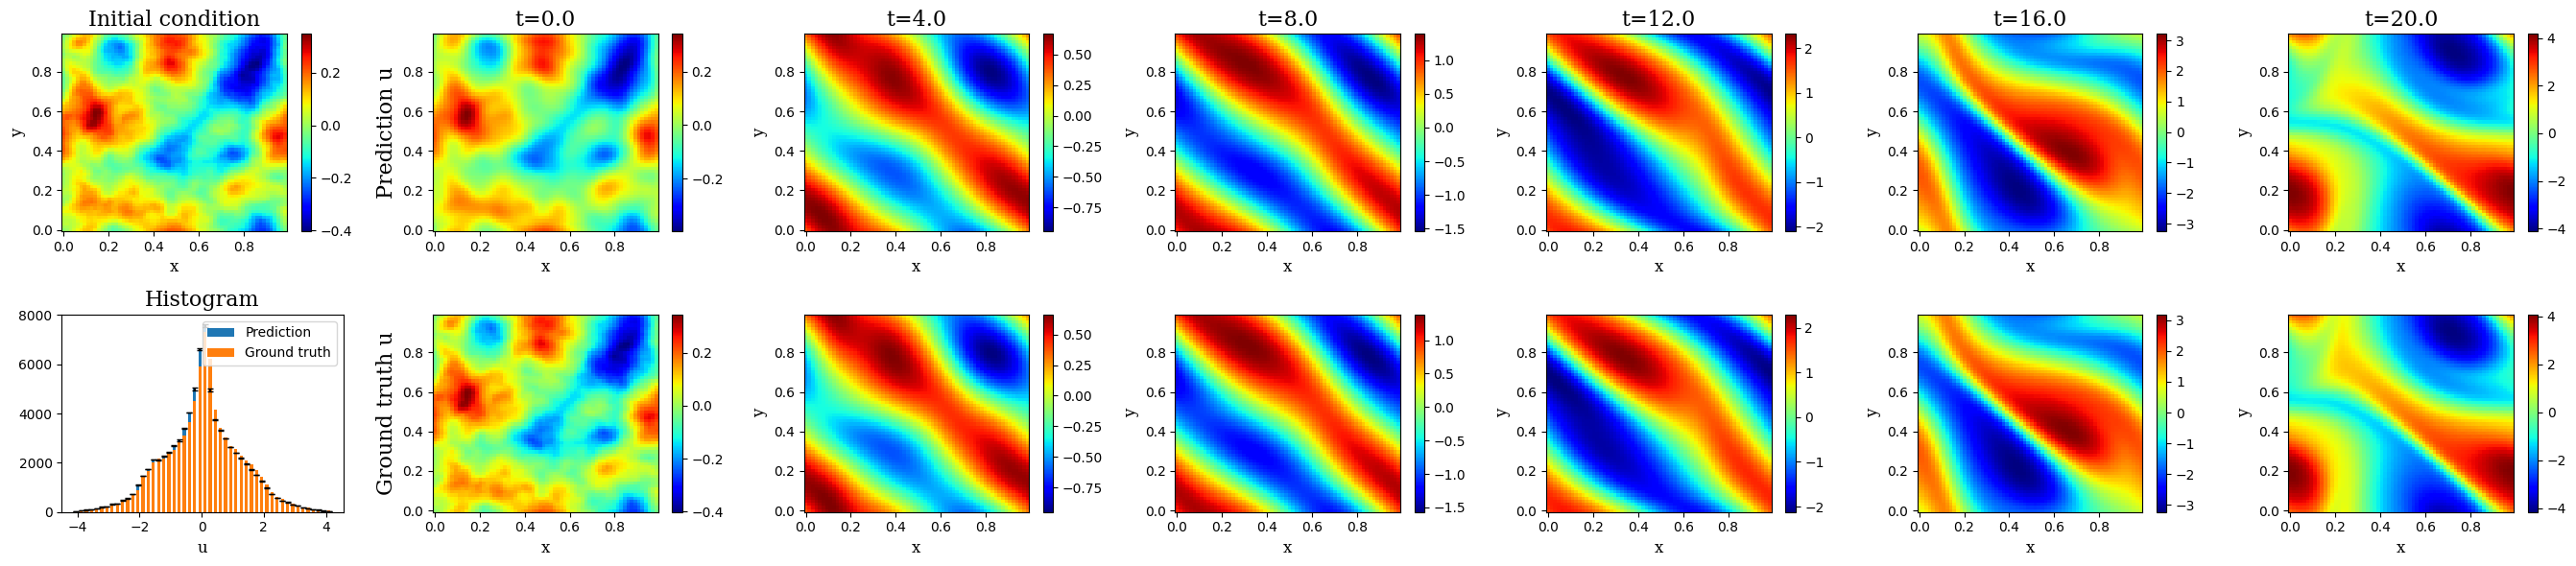

In [108]:
fig, ax = plt.subplots(2, 7, figsize=(27, 6))
im = ax[0, 0].pcolormesh(X, Y, initial_cond, cmap='jet', shading='auto')
ax[0, 0].set_title('Initial condition', fontfamily='serif', fontsize=16)
ax[0, 0].set_xlabel('x', fontfamily='serif', fontsize=12)
ax[0, 0].set_ylabel('y', fontfamily='serif', fontsize=12)
fig.colorbar(im, ax=ax[0, 0])

ax[1, 0].bar(bin_centers, hists_mean, width=0.1, label='Prediction')
ax[1, 0].bar(bin_centers, hist_ground_truth, width=0.1, label='Ground truth')
ax[1, 0].errorbar(bin_centers, hists_mean, yerr=hists_std, fmt='none', ecolor='black', capsize=2)
# add legend for this subplot only
handles, labels = ax[1, 0].get_legend_handles_labels()
ax[1, 0].legend(handles, labels, loc='upper right')
ax[1, 0].set_title('Histogram', fontfamily='serif', fontsize=16)
ax[1, 0].set_xlabel('u', fontfamily='serif', fontsize=12)

for i in range(5):
    im = ax[0, i+1].pcolormesh(X, Y, prediction_tile[0, i*4], cmap='jet', shading='auto')
    ax[0, i+1].set_title(f't={i*4:.1f}', fontfamily='serif', fontsize=16)
    ax[0, i+1].set_xlabel('x', fontfamily='serif', fontsize=12)
    ax[0, i+1].set_ylabel('y', fontfamily='serif', fontsize=12)
    fig.colorbar(im, ax=ax[0, i+1])

    im = ax[1, i+1].pcolormesh(X, Y, ground_truth[i*4], cmap='jet', shading='auto')
    ax[1, i+1].set_xlabel('x', fontfamily='serif', fontsize=12)
    ax[1, i+1].set_ylabel('y', fontfamily='serif', fontsize=12)
    fig.colorbar(im, ax=ax[1, i+1])

    if i == 0:
        ax[0, i+1].set_ylabel('Prediction u', fontfamily='serif', fontsize=16)
        ax[1, i+1].set_ylabel('Ground truth u', fontfamily='serif', fontsize=16)

im = ax[0, -1].pcolormesh(X, Y, prediction_tile[0, -1], cmap='jet', shading='auto')
ax[0, -1].set_title(f't=20.0', fontfamily='serif', fontsize=16)
ax[0, -1].set_xlabel('x', fontfamily='serif', fontsize=12)
ax[0, -1].set_ylabel('y', fontfamily='serif', fontsize=12)
fig.colorbar(im, ax=ax[0, -1])


im = ax[1, -1].pcolormesh(X, Y, ground_truth[-1], cmap='jet', shading='auto')
ax[1, -1].set_xlabel('x', fontfamily='serif', fontsize=12)
ax[1, -1].set_ylabel('y', fontfamily='serif', fontsize=12)
fig.colorbar(im, ax=ax[1, -1])
plt.tight_layout()
# plt.subplots_adjust(wspace=0.15, hspace=0.2)
plt.savefig("../ns_pred.png", dpi=300)